In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
csv_file="/content/drive/MyDrive/Colab Notebooks/Data Set - industrial_safety_and_health_database_with_accidents_description.csv"

In [3]:
pip install contractions

In [4]:
pip install autocorrect

In [5]:
pip install nlpaug

In [6]:
import numpy as np
import pandas as pd
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop = stopwords.words('english')
import pandas as pd
import contractions
from autocorrect import Speller
spell = Speller(lang='en')


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.regularizers import l1, l2, l1_l2
from keras.constraints import unit_norm

import pickle

from keras.layers.merge import Concatenate

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nlpaug.augmenter.word as naw

from tqdm import tqdm

from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, Conv1D
from sklearn import metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
df = pd.read_csv(csv_file)
df.sample(5)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
365,379,2017-04-04 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,"On 04/04/2017, around 13: 30hs, during the cur..."
389,403,2017-05-10 00:00:00,Country_01,Local_04,Mining,V,V,Male,Third Party,Fall,When performing shotcrete casting for resane o...
392,406,2017-05-16 00:00:00,Country_02,Local_12,Others,I,I,Male,Employee,Others,"The employee, as he passed the corner of the f..."
366,380,2017-04-06 00:00:00,Country_01,Local_06,Metals,I,II,Male,Third Party,Others,The industrial cleaning worker Cristian was pe...
33,33,2016-02-20 00:00:00,Country_01,Local_04,Mining,V,V,Male,Third Party,Others,Approximately 1:40 p.m. in circumstances that ...


Data Cleaning & Preprocessing

In [8]:
df.isna().any()

Unnamed: 0                  False
Data                        False
Countries                   False
Local                       False
Industry Sector             False
Accident Level              False
Potential Accident Level    False
Genre                       False
Employee or Third Party     False
Critical Risk               False
Description                 False
dtype: bool

Shape of the data

In [9]:
df.shape

(425, 11)

Datatype of each feature

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                425 non-null    int64 
 1   Data                      425 non-null    object
 2   Countries                 425 non-null    object
 3   Local                     425 non-null    object
 4   Industry Sector           425 non-null    object
 5   Accident Level            425 non-null    object
 6   Potential Accident Level  425 non-null    object
 7   Genre                     425 non-null    object
 8   Employee or Third Party   425 non-null    object
 9   Critical Risk             425 non-null    object
 10  Description               425 non-null    object
dtypes: int64(1), object(10)
memory usage: 36.6+ KB


In [11]:
# Check duplicates in a data frame
df.duplicated().sum()

0

In [12]:
# View the duplicate records
duplicates = df.duplicated()

df[duplicates]

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description


There are 7 duplicates in the dataset as below

We can remove the duplicate data as it is already a part of the dataset

Drop Duplicates

In [13]:
# Delete duplicate rows
df.drop_duplicates(inplace=True)

In [14]:
# shaape of the data
df.shape

(425, 11)

In [15]:
def preprocess_inputs(df):
  df= df.copy()

  #drop Unnamed column
  df.drop("Unnamed: 0", axis=1, inplace=True)

  #rename Columns- Data,Countries,Genre,Employee or Third Party
  df.rename(columns={'Data':'Date', 'Countries':'Country', 'Genre':'Gender', 'Employee or Third Party':'Employee type'}, inplace=True)

  # delete duplicated rows
  df.drop_duplicates(inplace=True)

  # remove spaces in columns name
  df.columns = df.columns.str.replace(' ','_')

  #replace roman numbers
  convert_roman = {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6}
  df.Accident_Level = df.Accident_Level.replace(convert_roman)
  df.Potential_Accident_Level = df.Potential_Accident_Level.replace(convert_roman)

  #df.Gender = df.Gender.replace({'Male': 1, 'Female': 0})


   # Adding Datetime Features such as year, Month and day
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df['Date'].apply(lambda x : x.year)
  df['Month'] = df['Date'].apply(lambda x : x.month)
  df['Day'] = df['Date'].apply(lambda x : x.day)
  df['Weekday'] = df['Date'].apply(lambda x : x.day_name())
  df['WeekofYear'] = df['Date'].apply(lambda x : x.weekofyear)

  #Month variable into season
  df['Season'] = df['Month'].apply(month2seasons)
  
  return df

  

In [16]:
# function to create month variable into seasons
def month2seasons(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2]:
        season = 'Summer'
    elif x in [3, 4, 5]:
        season = 'Autumn'
    elif x in [6, 7, 8]:
        season = 'Winter'
    return season

In [17]:
df = preprocess_inputs(df)

In [18]:
df.head()

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description,Year,Month,Day,Weekday,WeekofYear,Season
0,2016-01-01,Country_01,Local_01,Mining,1,4,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,53,Summer
1,2016-01-02,Country_02,Local_02,Mining,1,4,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,53,Summer
2,2016-01-06,Country_01,Local_03,Mining,1,3,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,1,Summer
3,2016-01-08,Country_01,Local_04,Mining,1,1,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8,Friday,1,Summer
4,2016-01-10,Country_01,Local_04,Mining,4,4,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,10,Sunday,1,Summer


In [19]:
df.isna().sum()

Date                        0
Country                     0
Local                       0
Industry_Sector             0
Accident_Level              0
Potential_Accident_Level    0
Gender                      0
Employee_type               0
Critical_Risk               0
Description                 0
Year                        0
Month                       0
Day                         0
Weekday                     0
WeekofYear                  0
Season                      0
dtype: int64

In [20]:
df.shape

(418, 16)

In [21]:
pip install autocorrect

In [22]:
pip install contractions

NLP_PreProcessing

In [23]:
class PreProcessing:
    def __init__(self, get_lower_case=False,
                        remove_whitespaces=False,
                        remove_spl_char=False,
                        replace_contractions=False,
                        split_attached_words=False,
                        get_spell_check=False,
                        remove_stop_words=False):
        self.get_lower_case=get_lower_case
        self.remove_whitespaces=remove_whitespaces
        self.remove_spl_char=remove_spl_char
        self.replace_contractions=replace_contractions
        self.split_attached_words=split_attached_words
        self.get_spell_check=get_spell_check
        self.remove_stop_words=remove_stop_words

     #returns the lowercased strings
    def getLowerCase(self, text):
        return text.lower()

    #words that are shortened by dropping letters and replacing them by an apostrophe
    def replaceContractions(self, text):
        return contractions.fix(text)
    
    def splitAttachedWords(self, text):
        return " ".join([s for s in re.split("([A-Z][a-z]+[^A-Z]*)",text) if s])

    #spell check
    def getSpellCheck(self, text):
        return spell(text)
    
    #remove spaces or specified characters at the start and end of a string
    def removeWhiteSpace(self, text):
        text = re.sub('\W+',' ',text)
        return text.strip()
    
    #remove Special Characters
    def removeSpecialCharacters(self,text):
        text=re.sub('[^A-Za-z0-9]+', ' ', text)
        return text
        
    # remove stop words
    def removeStopWords(self,text):
        words=nltk.tokenize.word_tokenize(text)
        words_new=[i for i in words if i not in stop]
        return " ".join(words_new)
      
    
    def preprocess(self, text):

        if self.get_lower_case:
            text = self.getLowerCase(text)

        if self.replace_contractions:
            text = self.replaceContractions(text)

        if self.split_attached_words:
            text = self.splitAttachedWords(text)
            
        if self.get_spell_check:
            text = self.getSpellCheck(text)

        if self.remove_spl_char:
            text = self.removeSpecialCharacters(text)

        if self.remove_whitespaces:
            text = self.removeWhiteSpace(text)
            
        if self.remove_stop_words:
            text=self.removeStopWords(text)

        return text

In [24]:
pp = PreProcessing(get_lower_case=True,
remove_whitespaces=True,
remove_spl_char=True,
replace_contractions=True,
split_attached_words=True,
get_spell_check=True,
remove_stop_words=True)

In [25]:
df['Description_normalized']=df['Description'].apply(pp.preprocess)

In [26]:
df.isna().sum()

Date                        0
Country                     0
Local                       0
Industry_Sector             0
Accident_Level              0
Potential_Accident_Level    0
Gender                      0
Employee_type               0
Critical_Risk               0
Description                 0
Year                        0
Month                       0
Day                         0
Weekday                     0
WeekofYear                  0
Season                      0
Description_normalized      0
dtype: int64

In [27]:
df.head(10)

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description,Year,Month,Day,Weekday,WeekofYear,Season,Description_normalized
0,2016-01-01,Country_01,Local_01,Mining,1,4,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,53,Summer,removing drill rod jumbo 08 maintenance superv...
1,2016-01-02,Country_02,Local_02,Mining,1,4,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,53,Summer,activation sodium sulfide pump piping coupled ...
2,2016-01-06,Country_01,Local_03,Mining,1,3,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,1,Summer,sub station mile located level 170 collaborato...
3,2016-01-08,Country_01,Local_04,Mining,1,1,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8,Friday,1,Summer,9 45 approximately nv 1880 cx 695 ob7 personne...
4,2016-01-10,Country_01,Local_04,Mining,4,4,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,10,Sunday,1,Summer,approximately 11 45 circumstances mechanics an...
5,2016-01-12,Country_02,Local_05,Metals,1,3,Male,Third Party (Remote),Pressurized Systems,During the unloading operation of the ustulado...,2016,1,12,Tuesday,2,Summer,unloading operation ustulado bag need uncle di...
6,2016-01-16,Country_02,Local_05,Metals,1,3,Male,Employee,Fall prevention (same level),The collaborator reports that he was on street...,2016,1,16,Saturday,2,Summer,collaborator reports street 09 holding left ha...
7,2016-01-17,Country_01,Local_04,Mining,1,3,Male,Third Party,Pressed,"At approximately 04:50 p.m., when the mechanic...",2016,1,17,Sunday,2,Summer,approximately 04 50 p mechanic technician jos ...
8,2016-01-19,Country_02,Local_02,Mining,1,4,Male,Third Party (Remote),Others,Employee was sitting in the resting area at le...,2016,1,19,Tuesday,3,Summer,employee sitting resting area level 326 raise ...
9,2016-01-26,Country_01,Local_06,Metals,1,2,Male,Third Party,Chemical substances,At the moment the forklift operator went to ma...,2016,1,26,Tuesday,4,Summer,moment forklift operator went manipulate big b...


In [28]:
df

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description,Year,Month,Day,Weekday,WeekofYear,Season,Description_normalized
0,2016-01-01,Country_01,Local_01,Mining,1,4,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,53,Summer,removing drill rod jumbo 08 maintenance superv...
1,2016-01-02,Country_02,Local_02,Mining,1,4,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,53,Summer,activation sodium sulfide pump piping coupled ...
2,2016-01-06,Country_01,Local_03,Mining,1,3,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,1,Summer,sub station mile located level 170 collaborato...
3,2016-01-08,Country_01,Local_04,Mining,1,1,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8,Friday,1,Summer,9 45 approximately nv 1880 cx 695 ob7 personne...
4,2016-01-10,Country_01,Local_04,Mining,4,4,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,10,Sunday,1,Summer,approximately 11 45 circumstances mechanics an...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,2017-07-04,Country_01,Local_04,Mining,1,3,Male,Third Party,Others,"Being approximately 5:00 a.m. approximately, w...",2017,7,4,Tuesday,27,Winter,approximately 5 00 approximately lifting kelly...
421,2017-07-04,Country_01,Local_03,Mining,1,2,Female,Employee,Others,The collaborator moved from the infrastructure...,2017,7,4,Tuesday,27,Winter,collaborator moved infrastructure office julio...
422,2017-07-05,Country_02,Local_09,Metals,1,2,Male,Employee,Venomous Animals,During the environmental monitoring activity i...,2017,7,5,Wednesday,27,Winter,environmental monitoring activity area employe...
423,2017-07-06,Country_02,Local_05,Metals,1,2,Male,Employee,Cut,The Employee performed the activity of strippi...,2017,7,6,Thursday,27,Winter,employee performed activity stripping cathode ...


Get the Length of each line and find the maximum length

In [29]:
# Get length of each line
df['line_length'] = df['Description_normalized'].str.len()

print('Minimum line length: {}'.format(df['line_length'].min()))
print('Maximum line length: {}'.format(df['line_length'].max()))
print('Line with maximum length: {}'.format(df[df['line_length'] == df['line_length'].max()]['Description_normalized'].values[0]))

Minimum line length: 61
Maximum line length: 682
Line with maximum length: level 3490 gallery 239 holding activity bolster equipment 24 operator performs drilling first hole support right gable 7 foot deep drill end drill rod breaks leaving threads inside drilling machine thank operator assistant decide make two empty percussion attempts free threads thank without success third attempt assistant enters 3 8 corrugated iron central hole rest bar embedded thank generate pressure moment operator activates percussion generates movement thank hits palm victim left hand generating described injury worker wearing safety gloves time accident end corrugated iron contact left hand shaped like cane worker time accident positioned roof supported mesh split set


In [30]:
# Get length of each line
df['nb_words'] = df['Description_normalized'].apply(lambda x: len(str(x).split(' ')))

print('Minimum number of words: {}'.format(df['nb_words'].min()))
print('Maximum number of words: {}'.format(df['nb_words'].max()))
print('Line with maximum number of words: {}'.format(df[df['nb_words'] == df['nb_words'].max()]['Description_normalized'].values[0]))

Minimum number of words: 9
Maximum number of words: 99
Line with maximum number of words: level 3490 gallery 239 holding activity bolster equipment 24 operator performs drilling first hole support right gable 7 foot deep drill end drill rod breaks leaving threads inside drilling machine thank operator assistant decide make two empty percussion attempts free threads thank without success third attempt assistant enters 3 8 corrugated iron central hole rest bar embedded thank generate pressure moment operator activates percussion generates movement thank hits palm victim left hand generating described injury worker wearing safety gloves time accident end corrugated iron contact left hand shaped like cane worker time accident positioned roof supported mesh split set


In [31]:
df.head(20)

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description,Year,Month,Day,Weekday,WeekofYear,Season,Description_normalized,line_length,nb_words
0,2016-01-01,Country_01,Local_01,Mining,1,4,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,53,Summer,removing drill rod jumbo 08 maintenance superv...,281,38
1,2016-01-02,Country_02,Local_02,Mining,1,4,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,53,Summer,activation sodium sulfide pump piping coupled ...,204,28
2,2016-01-06,Country_01,Local_03,Mining,1,3,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,1,Summer,sub station mile located level 170 collaborato...,198,30
3,2016-01-08,Country_01,Local_04,Mining,1,1,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8,Friday,1,Summer,9 45 approximately nv 1880 cx 695 ob7 personne...,366,55
4,2016-01-10,Country_01,Local_04,Mining,4,4,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,10,Sunday,1,Summer,approximately 11 45 circumstances mechanics an...,329,52
5,2016-01-12,Country_02,Local_05,Metals,1,3,Male,Third Party (Remote),Pressurized Systems,During the unloading operation of the ustulado...,2016,1,12,Tuesday,2,Summer,unloading operation ustulado bag need uncle di...,215,26
6,2016-01-16,Country_02,Local_05,Metals,1,3,Male,Employee,Fall prevention (same level),The collaborator reports that he was on street...,2016,1,16,Saturday,2,Summer,collaborator reports street 09 holding left ha...,158,22
7,2016-01-17,Country_01,Local_04,Mining,1,3,Male,Third Party,Pressed,"At approximately 04:50 p.m., when the mechanic...",2016,1,17,Sunday,2,Summer,approximately 04 50 p mechanic technician jos ...,257,35
8,2016-01-19,Country_02,Local_02,Mining,1,4,Male,Third Party (Remote),Others,Employee was sitting in the resting area at le...,2016,1,19,Tuesday,3,Summer,employee sitting resting area level 326 raise ...,109,15
9,2016-01-26,Country_01,Local_06,Metals,1,2,Male,Third Party,Chemical substances,At the moment the forklift operator went to ma...,2016,1,26,Tuesday,4,Summer,moment forklift operator went manipulate big b...,260,36


In [32]:
df.isna().sum()

Date                        0
Country                     0
Local                       0
Industry_Sector             0
Accident_Level              0
Potential_Accident_Level    0
Gender                      0
Employee_type               0
Critical_Risk               0
Description                 0
Year                        0
Month                       0
Day                         0
Weekday                     0
WeekofYear                  0
Season                      0
Description_normalized      0
line_length                 0
nb_words                    0
dtype: int64

Feature Engineering

In [33]:
def feature_engineering(df):
  df= df.copy()

  # Create Industry DataFrame
  indus_df = pd.DataFrame()

  # Label encoding season
  df['Season'] = df['Season'].replace('Summer', 'aSummer').replace('Autumn', 'bAutumn').replace('Winter', 'cWinter').replace('Spring', 'dSpring')
  indus_df['Season'] = LabelEncoder().fit_transform(df['Season']).astype(np.int8)


  # Label encoding Weekday
  df['Weekday'] = df['Weekday'].replace('Monday', 'aMonday').replace('Tuesday', 'bTuesday').replace('Wednesday', 'cWednesday').replace('Thursday', 'dThursday').replace('Friday', 'eFriday').replace('Saturday', 'fSaturday').replace('Sunday', 'gSunday')
  indus_df['Weekday'] = LabelEncoder().fit_transform(df['Weekday']).astype(np.int8)


  # Label encoding Accident_Level
  indus_df['Accident_Level'] = LabelEncoder().fit_transform(df['Accident_Level']).astype(np.int8)


  # Label encoding Potential_Accident_Level
  indus_df['Potential_Accident_Level'] = LabelEncoder().fit_transform(df['Potential_Accident_Level']).astype(np.int8)


  # Dummy variables encoding
  Country_dummies = pd.get_dummies(df['Country'], columns=["Country"], drop_first=True)
  Local_dummies = pd.get_dummies(df['Local'], columns=["Local"], drop_first=True)
  Gender_dummies = pd.get_dummies(df['Gender'], columns=["Gender"], drop_first=True)
  IS_dummies = pd.get_dummies(df['Industry_Sector'], columns=['Industry_Sector'], prefix='IS', drop_first=True)
  EmpType_dummies = pd.get_dummies(df['Employee_type'], columns=['Employee_type'], prefix='EmpType', drop_first=True)
  CR_dummies = pd.get_dummies(df['Critical_Risk'], columns=['Critical_Risk'], prefix='CR', drop_first=True)

  # Merge the above dataframe with the original dataframe indus_df
  indus_df = indus_df.join(Country_dummies.reset_index(drop=True)).join(Local_dummies.reset_index(drop=True)).join(Gender_dummies.reset_index(drop=True)).join(IS_dummies.reset_index(drop=True)).join(EmpType_dummies.reset_index(drop=True)).join(CR_dummies.reset_index(drop=True))

  indus_df = df[['Year','Month','Day','WeekofYear']].reset_index(drop=True).join(indus_df.reset_index(drop=True))

  return indus_df



In [34]:
# Create Industry DataFrame
indus_df = pd.DataFrame()
indus_df = feature_engineering(df)

In [35]:
indus_df.head()

,Year,Month,Day,WeekofYear,Season,Weekday,Accident_Level,Potential_Accident_Level,Country_02,Country_03,Local_02,Local_03,Local_04,Local_05,Local_06,Local_07,Local_08,Local_09,Local_10,Local_11,Local_12,Male,IS_Mining,IS_Others,EmpType_Third Party,EmpType_Third Party (Remote),CR_Bees,CR_Blocking and isolation of energies,CR_Burn,CR_Chemical substances,CR_Confined space,CR_Cut,CR_Electrical Shock,CR_Electrical installation,CR_Fall,CR_Fall prevention,CR_Fall prevention (same level),CR_Individual protection equipment,CR_Liquid Metal,CR_Machine Protection,CR_Manual Tools,CR_Others,CR_Plates,CR_Poll,CR_Power lock,CR_Pressed,CR_Pressurized Systems,CR_Pressurized Systems / Chemical Substances,CR_Projection,CR_Projection of fragments,CR_Projection/Burning,CR_Projection/Choco,CR_Projection/Manual Tools,CR_Suspended Loads,CR_Traffic,CR_Vehicles and Mobile Equipment,CR_Venomous Animals,CR_remains of choco
0,2016,1,1,53,0,4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2016,1,2,53,0,5,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2016,1,6,1,0,2,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2016,1,8,1,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016,1,10,1,0,6,3,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
len(indus_df.columns)

58

In [37]:
# Check NaN values
np.any(np.isnan(indus_df))

False

In [38]:
indus_df

,Year,Month,Day,WeekofYear,Season,Weekday,Accident_Level,Potential_Accident_Level,Country_02,Country_03,Local_02,Local_03,Local_04,Local_05,Local_06,Local_07,Local_08,Local_09,Local_10,Local_11,Local_12,Male,IS_Mining,IS_Others,EmpType_Third Party,EmpType_Third Party (Remote),CR_Bees,CR_Blocking and isolation of energies,CR_Burn,CR_Chemical substances,CR_Confined space,CR_Cut,CR_Electrical Shock,CR_Electrical installation,CR_Fall,CR_Fall prevention,CR_Fall prevention (same level),CR_Individual protection equipment,CR_Liquid Metal,CR_Machine Protection,CR_Manual Tools,CR_Others,CR_Plates,CR_Poll,CR_Power lock,CR_Pressed,CR_Pressurized Systems,CR_Pressurized Systems / Chemical Substances,CR_Projection,CR_Projection of fragments,CR_Projection/Burning,CR_Projection/Choco,CR_Projection/Manual Tools,CR_Suspended Loads,CR_Traffic,CR_Vehicles and Mobile Equipment,CR_Venomous Animals,CR_remains of choco
0,2016,1,1,53,0,4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2016,1,2,53,0,5,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2016,1,6,1,0,2,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2016,1,8,1,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016,1,10,1,0,6,3,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2017,7,4,27,2,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
414,2017,7,4,27,2,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
415,2017,7,5,27,2,2,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
416,2017,7,6,27,2,3,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
df["Accident_Level"].value_counts(normalize=True)

1    0.739234
2    0.095694
3    0.074163
4    0.071770
5    0.019139
Name: Accident_Level, dtype: float64

Design, train and test RNN or LSTM classifiers

model with Text inputs (accident description alone)

In [39]:
# Select input and output features
X_text = df['Description_normalized']
y_text = df['Accident_Level']

In [40]:
X_text

0      removing drill rod jumbo 08 maintenance superv...
1      activation sodium sulfide pump piping coupled ...
2      sub station mile located level 170 collaborato...
3      9 45 approximately nv 1880 cx 695 ob7 personne...
4      approximately 11 45 circumstances mechanics an...
                             ...                        
420    approximately 5 00 approximately lifting kelly...
421    collaborator moved infrastructure office julio...
422    environmental monitoring activity area employe...
423    employee performed activity stripping cathode ...
424    10 00 assistant cleaned floor module e central...
Name: Description_normalized, Length: 418, dtype: object

In [41]:
# Encode labels in column 'Accident Level'.
from sklearn.preprocessing import LabelEncoder
y_text = LabelEncoder().fit_transform(y_text)

In [42]:
# pre-processing methods
from sklearn.model_selection import train_test_split

# Divide our data into testing and training sets:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size = 0.20, random_state = 1, stratify = y_text)

print('X_text_train shape : ({0})'.format(X_text_train.shape[0]))
print('y_text_train shape : ({0},)'.format(y_text_train.shape[0]))
print('X_text_test shape : ({0})'.format(X_text_test.shape[0]))
print('y_text_test shape : ({0},)'.format(y_text_test.shape[0]))

X_text_train shape : (334)
y_text_train shape : (334,)
X_text_test shape : (84)
y_text_test shape : (84,)


In [43]:
from keras.utils import np_utils
# Convert both the training and test labels into one-hot encoded vectors:
# Convert both the training and test labels into one-hot encoded vectors:
y_text_train = np_utils.to_categorical(y_text_train)
y_text_test = np_utils.to_categorical(y_text_test)

In [44]:
y_text_train

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [45]:
X_text_train[0]

'removing drill rod jumbo 08 maintenance supervisor proceeds loose support intermediate centralized facilitate removal seeing mechanic supports one end drill equipment pull hands bar accelerate removal moment bar slides point support tighten fingers mechanic drilling bar beam jumbo'

In [46]:
pip install nlpaug

In [47]:
# Keras pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_text_train)

X_text_train = tokenizer.texts_to_sequences(X_text_train)
X_text_test = tokenizer.texts_to_sequences(X_text_test)

In [48]:
# Sentences can have different lengths, and therefore the sequences returned by the Tokenizer class also consist of variable lengths.
# We need to pad the our sequences using the max length.
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:", vocab_size)

maxlen = 100

X_text_train = pad_sequences(X_text_train, padding='post', maxlen=maxlen)
X_text_test = pad_sequences(X_text_test, padding='post', maxlen=maxlen)

vocab_size: 2889


In [49]:
X_text_train[0].size

100

In [50]:
embedding_size = 50
embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/Colab Notebooks/glove.6B.50d (3).txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

len(embeddings_dictionary.values())

400000

In [51]:
print(embedding_matrix.shape)

(2889, 50)


In [52]:
from keras.layers import Input
from tensorflow.keras.layers import Flatten, Activation, Dense, LSTM, BatchNormalization, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from tensorflow.keras.optimizers import SGD
# Build a LSTM Neural Network
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=False)(deep_inputs)

LSTM_Layer_1 = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
max_pool_layer_1 = GlobalMaxPool1D()(LSTM_Layer_1)
drop_out_layer_1 = Dropout(0.5, input_shape = (256,))(max_pool_layer_1)
dense_layer_1 = Dense(128, activation = 'relu')(drop_out_layer_1)
drop_out_layer_2 = Dropout(0.5, input_shape = (128,))(dense_layer_1)
dense_layer_2 = Dense(64, activation = 'relu')(drop_out_layer_2)
drop_out_layer_3 = Dropout(0.5, input_shape = (64,))(dense_layer_2)
dense_layer_3 = Dense(32, activation = 'relu')(drop_out_layer_3)
drop_out_layer_4 = Dropout(0.5, input_shape = (32,))(dense_layer_3)
dense_layer_4 = Dense(10, activation = 'relu')(drop_out_layer_4)
drop_out_layer_5 = Dropout(0.5, input_shape = (10,))(dense_layer_4)
dense_layer_5 = Dense(5, activation='softmax')(drop_out_layer_5)
model_lstm_text_input = Model(inputs=deep_inputs, outputs=dense_layer_5)
opt = SGD(learning_rate=0.001, momentum=0.9)
model_lstm_text_input.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [53]:
print(model_lstm_text_input.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           144450    
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         183296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896 

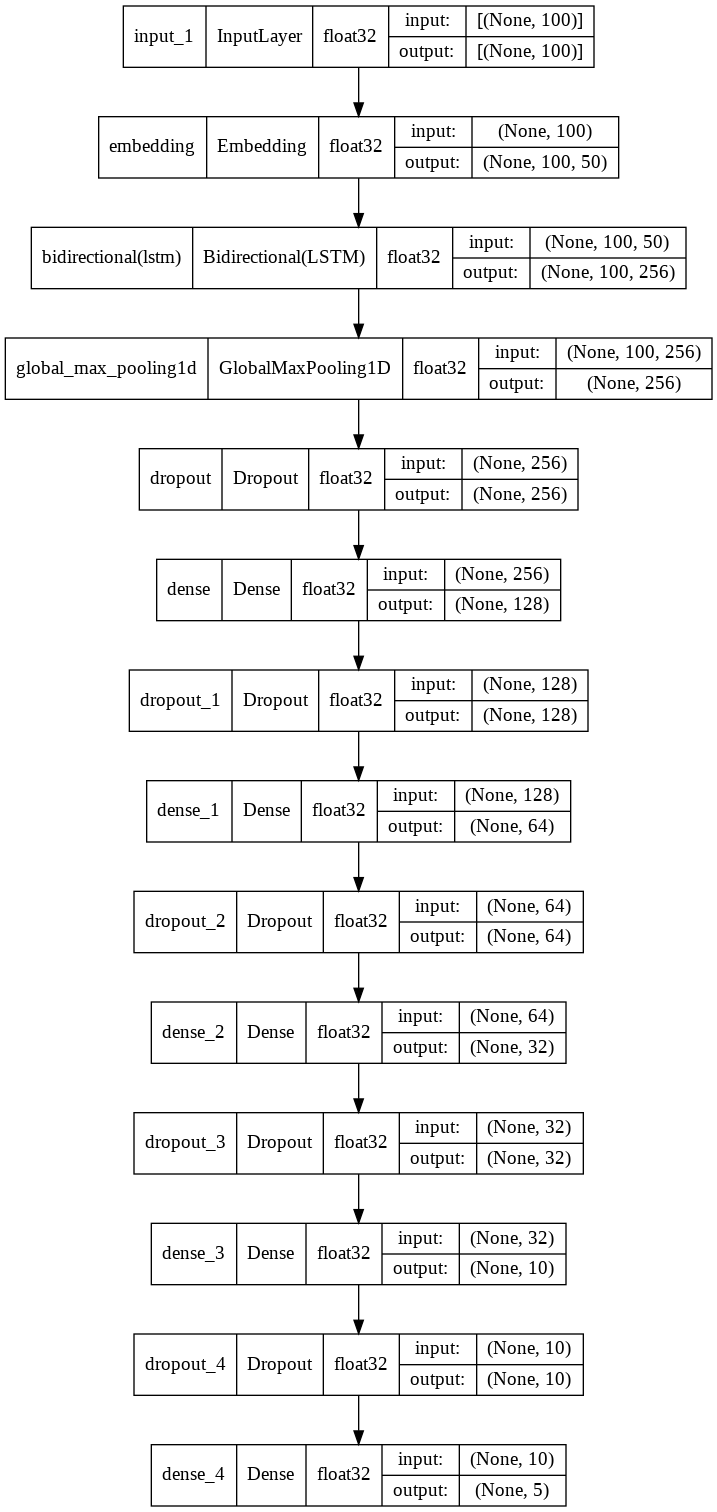

In [54]:
from keras.utils.vis_utils import plot_model
plot_model(model_lstm_text_input, to_file='model_plot1.png', show_shapes=True, show_dtype=True, show_layer_names=True)

In [55]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [56]:
class Metrics(tf.keras.callbacks.Callback):

    def __init__(self, validation_data=()):
        super().__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        xVal, yVal, target_type = self.validation_data
        if target_type == 'multi_class':
          val_predict_classes = model.predict_classes(xVal, verbose=0) # Multiclass
        else:
          val_predict_classes = (np.asarray(self.model.predict(xVal))).round() # Multilabel
        
        
        val_targ = yVal

        _val_f1 = f1_score(val_targ, val_predict_classes, average='micro')
        _val_recall = recall_score(val_targ, val_predict_classes, average='micro')
        _val_precision = precision_score(val_targ, val_predict_classes, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        #print("— train_f1: %f — train_precision: %f — train_recall %f" % (_val_f1, _val_precision, _val_recall))
        return

In [57]:
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
# Use earlystopping
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, min_delta=1E-3)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=5, min_delta=1E-4)

target_type = 'multi_label'
metrics = Metrics(validation_data=(X_text_train, y_text_train, target_type))

# fit the keras model on the dataset
training_history = model_lstm_text_input.fit(X_text_train, y_text_train, epochs=100, batch_size=8, verbose=1, validation_data=(X_text_test, y_text_test), callbacks=[rlrp, metrics])

Epoch 1/100
42/42 [==============================] - 22s 407ms/step - loss: 1.6840 - acc: 0.3293 - val_loss: 1.4841 - val_acc: 0.7381 - lr: 0.0010


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100
42/42 [==============================] - 12s 293ms/step - loss: 1.4144 - acc: 0.6617 - val_loss: 1.3452 - val_acc: 0.7381 - lr: 0.0010


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/100
42/42 [==============================] - 12s 282ms/step - loss: 1.3042 - acc: 0.7186 - val_loss: 1.2372 - val_acc: 0.7381 - lr: 0.0010


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100
42/42 [==============================] - 11s 265ms/step - loss: 1.1924 - acc: 0.7395 - val_loss: 1.1406 - val_acc: 0.7381 - lr: 0.0010


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/100
42/42 [==============================] - 8s 186ms/step - loss: 1.1397 - acc: 0.7395 - val_loss: 1.0805 - val_acc: 0.7381 - lr: 0.0010
Epoch 6/100
 1/42 [..............................] - ETA: 4s - loss: 0.8541 - acc: 0.8750

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 6s 142ms/step - loss: 1.0727 - acc: 0.7395 - val_loss: 1.0346 - val_acc: 0.7381 - lr: 0.0010
Epoch 7/100
42/42 [==============================] - 6s 143ms/step - loss: 1.0315 - acc: 0.7395 - val_loss: 1.0021 - val_acc: 0.7381 - lr: 0.0010
Epoch 8/100
42/42 [==============================] - 6s 146ms/step - loss: 1.0171 - acc: 0.7395 - val_loss: 0.9829 - val_acc: 0.7381 - lr: 0.0010
Epoch 9/100
42/42 [==============================] - 6s 143ms/step - loss: 0.9877 - acc: 0.7395 - val_loss: 0.9686 - val_acc: 0.7381 - lr: 0.0010
Epoch 10/100
42/42 [==============================] - 6s 146ms/step - loss: 0.9758 - acc: 0.7395 - val_loss: 0.9588 - val_acc: 0.7381 - lr: 0.0010
Epoch 11/100
42/42 [==============================] - 6s 146ms/step - loss: 0.9587 - acc: 0.7395 - val_loss: 0.9508 - val_acc: 0.7381 - lr: 0.0010
Epoch 12/100
42/42 [==============================] - 6s 149ms/step - loss: 0.9489 - acc: 0.7395 - val_loss: 0.9453 - val_acc: 0.7381 

In [58]:
# evaluate the keras model
_, train_accuracy = model_lstm_text_input.evaluate(X_text_train, y_text_train, batch_size=8, verbose=0)
_, test_accuracy = model_lstm_text_input.evaluate(X_text_test, y_text_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 73.95
Test accuracy: 73.81


In [59]:
 #get the accuracy, precision, recall, f1 score from model
def get_classification_metrics(model_lstm_text_input, X_test, y_test, target_type):
  
  # predict probabilities for test set
  yhat_probs = model_lstm_text_input.predict(X_test, verbose=0) # Multiclass

  # predict crisp classes for test set
  if target_type == 'multi_class':
    yhat_classes = model_lstm_text_input.predict_classes(X_test, verbose=0) # Multiclass
  else:
    yhat_classes = (np.asarray(model_lstm_text_input.predict(X_test))).round() # Multilabel

  # reduce to 1d array
  yhat_probs = yhat_probs[:, 0]

  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_test, yhat_classes)

  # precision tp / (tp + fp)
  precision = precision_score(y_test, yhat_classes, average='micro')

  # recall: tp / (tp + fn)
  recall = recall_score(y_test, yhat_classes, average='micro')

  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test, yhat_classes, average='micro')

  return accuracy, precision, recall, f1

In [60]:
accuracy, precision, recall, f1 = get_classification_metrics(model_lstm_text_input, X_text_test, y_text_test, target_type)
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)

Accuracy: 0.738095
Precision: 0.738095
Recall: 0.738095
F1 score: 0.738095


Text(0.5, 1.0, 'Training and validation loss')

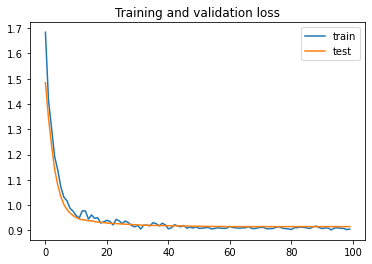

In [61]:
epochs = range(len(training_history.history['loss'])) # Get number of epochs

# plot loss learning curves
plt.plot(epochs, training_history.history['loss'], label = 'train')
plt.plot(epochs, training_history.history['val_loss'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

The above one is good fit

Text(0.5, 1.0, 'Training and validation accuracy')

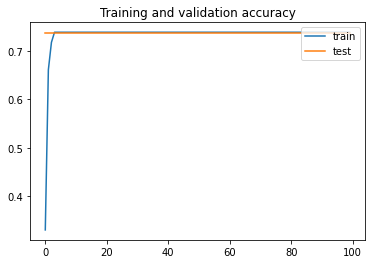

In [62]:
# plot accuracy learning curves
plt.plot(epochs, training_history.history['acc'], label = 'train')
plt.plot(epochs, training_history.history['val_acc'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation accuracy')

In [63]:
y_predti = model_lstm_text_input.predict(X_text_test)

In [65]:
y_predti.shape

(84, 5)

In [67]:
y_pred_ti=np.argmax(y_predti, axis=1)

In [68]:
y_pred_ti.shape

(84,)

In [69]:
y_test_ci=np.argmax(y_text_test, axis=1)

In [70]:
y_test_ci.shape

(84,)

In [71]:
y_pred_ti=np.argmax(y_predti, axis=1)
y_test_ci=np.argmax(y_text_test, axis=1)
from sklearn import metrics
print('Report:' + '\n', metrics.classification_report(y_test_ci,y_pred_ti))
print('Cm:' + '\n', metrics.confusion_matrix(y_test_ci,y_pred_ti))

Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85        62
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.74        84
   macro avg       0.15      0.20      0.17        84
weighted avg       0.54      0.74      0.63        84

Cm:
 [[62  0  0  0  0]
 [ 8  0  0  0  0]
 [ 6  0  0  0  0]
 [ 6  0  0  0  0]
 [ 2  0  0  0  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


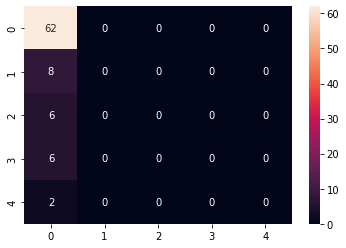

In [75]:
cm_ti=metrics.confusion_matrix(y_test_ci,y_pred_ti)
f = sns.heatmap(cm_ti, annot=True, fmt='d')

In [ ]:
# serialize model to JSON
model_lstm_text_input_json = model_lstm_text_input.to_json()
with open("model_lstm_text_input.json", "w") as json_file:
    json_file.write(model_lstm_text_input_json)
    
# serialize weights to HDF5
model_lstm_text_input.save_weights("model_lstm_text_input.h5")
print("Saved model weights to disk")

# Save the model in h5 format 
model_lstm_text_input.save("model_lstm_text_input_finalized_keras.h5")
print("Saved model to disk")

#Pickle file
filename = 'model_lstm_text_input.pkl'
pickle.dump(model_lstm_text_input, open(filename, 'wb'))

Saved model weights to disk
Saved model to disk


INFO:tensorflow:Assets written to: ram://2587d081-1605-4a45-a007-76b900500edb/assets


INFO:tensorflow:Assets written to: ram://2587d081-1605-4a45-a007-76b900500edb/assets


Creating a Model with Categorical features Only

In [ ]:
# Select input and output features
X_cat = indus_df[['Year','Month','Day','Country_02','Country_03']]
y_cat = df['Accident_Level']

In [ ]:
# Encode labels in column 'Accident Level'.
y_cat = LabelEncoder().fit_transform(y_cat)

In [ ]:
# Divide our data into testing and training sets:
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, test_size = 0.20, random_state = 1, stratify = y_cat)

print('X_cat_train shape : ({0})'.format(X_cat_train.shape[0]))
print('y_cat_train shape : ({0},)'.format(y_cat_train.shape[0]))
print('X_cat_test shape : ({0})'.format(X_cat_test.shape[0]))
print('y_cat_test shape : ({0},)'.format(y_cat_test.shape[0]))

X_cat_train shape : (334)
y_cat_train shape : (334,)
X_cat_test shape : (84)
y_cat_test shape : (84,)


In [ ]:
# Convert both the training and test labels into one-hot encoded vectors:
y_cat_train = np_utils.to_categorical(y_cat_train)
y_cat_test = np_utils.to_categorical(y_cat_test)

In [ ]:
X_cat_train.iloc[:]

,Year,Month,Day,Country_02,Country_03
202,2016,9,1,1,0
258,2016,11,29,1,0
6,2016,1,16,1,0
84,2016,4,7,0,0
338,2017,2,27,0,0
...,...,...,...,...,...
14,2016,2,4,1,0
55,2016,3,14,0,0
173,2016,7,16,0,0
7,2016,1,17,0,0


In [ ]:
# Variable transformation using StandardScaler
scaler_X = StandardScaler()#StandardScaler()
X_cat_train.iloc[:,:6] = scaler_X.fit_transform(X_cat_train.iloc[:,:6]) # Scaling only first 6 feautres

X_cat_test.iloc[:,:6] = scaler_X.fit_transform(X_cat_test.iloc[:,:6]) # Scaling only first 6 feautres

In [ ]:
X_cat_train.shape[1]

5

In [ ]:
param = 1e-4
input2 = Input(shape=(X_cat_train.shape[1],))
dense_layer_1 = Dense(10, input_dim=X_cat_train.shape[1], activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(param),kernel_constraint=unit_norm())(input2)
drop_out_layer_1 = Dropout(0.2)(dense_layer_1)
batch_norm_layer_1 = BatchNormalization()(drop_out_layer_1)

dense_layer_2 = Dense(10, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(param),kernel_constraint=unit_norm())(batch_norm_layer_1)
drop_out_layer_2 = Dropout(0.5)(dense_layer_2)
batch_norm_layer_2 = BatchNormalization()(drop_out_layer_2)

dense_layer_3 = Dense(5, activation='softmax', kernel_regularizer=l2(param), kernel_constraint=unit_norm())(batch_norm_layer_2)

model_Categorical_input = Model(inputs=input2, outputs=dense_layer_3)

opt = SGD(learning_rate=0.001, momentum=0.9)

model_Categorical_input.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [ ]:
print(model_Categorical_input.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_5 (Dense)             (None, 10)                60        
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 batch_normalization (BatchN  (None, 10)               40        
 ormalization)                                                   
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dropout_6 (Dropout)         (None, 10)                0         
                                                           

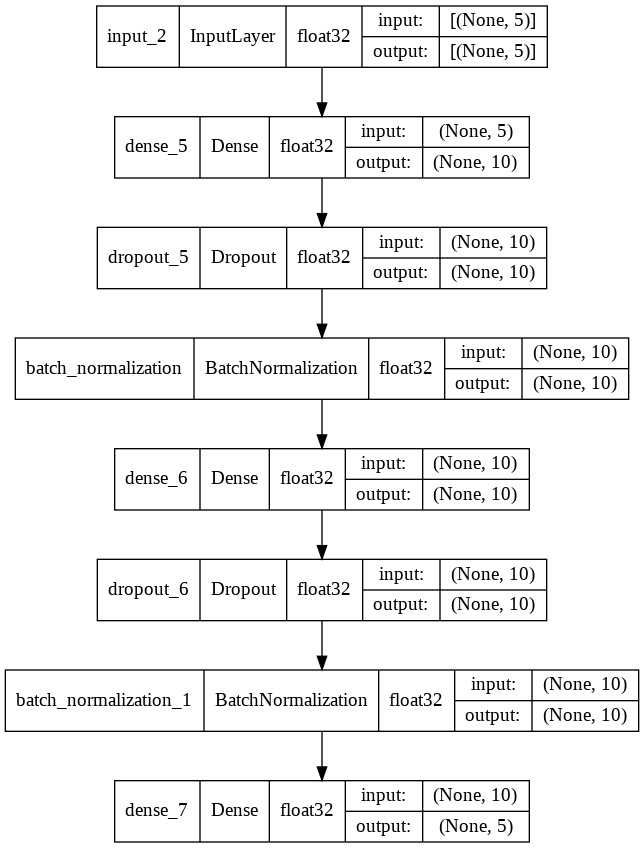

In [ ]:
plot_model(model_Categorical_input, to_file='model_plot1.png', show_shapes=True, show_dtype=True, show_layer_names=True)

In [ ]:
# Use earlystopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, min_delta=1E-3)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=5, min_delta=1E-4)

target_type = 'multi_label'
metrics = Metrics(validation_data=(X_cat_train, y_cat_train, target_type))

# fit the keras model on the dataset
training_history = model_Categorical_input.fit(X_cat_train, y_cat_train, epochs=100, batch_size=8, verbose=1, validation_data=(X_cat_test, y_cat_test), callbacks=[rlrp, metrics])

Epoch 1/100
42/42 [==============================] - 2s 17ms/step - loss: 1.8574 - acc: 0.2725 - val_loss: 1.4039 - val_acc: 0.4524 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - 0s 10ms/step - loss: 1.5771 - acc: 0.3683 - val_loss: 1.1916 - val_acc: 0.7143 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - 0s 10ms/step - loss: 1.3438 - acc: 0.5030 - val_loss: 1.0671 - val_acc: 0.7381 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - 0s 9ms/step - loss: 1.1938 - acc: 0.5868 - val_loss: 1.0034 - val_acc: 0.7381 - lr: 0.0010
Epoch 5/100
42/42 [==============================] - 0s 11ms/step - loss: 1.2388 - acc: 0.6078 - val_loss: 0.9792 - val_acc: 0.7381 - lr: 0.0010
Epoch 6/100
42/42 [==============================] - 0s 10ms/step - loss: 1.1295 - acc: 0.6587 - val_loss: 0.9590 - val_acc: 0.7381 - lr: 0.0010
Epoch 7/100
42/42 [==============================] - 0s 10ms/step - loss: 1.0873 - acc: 0.6916 - val_loss: 0.9486 - val_acc: 0.7381

In [ ]:
# evaluate the keras model
_, train_accuracy = model_Categorical_input.evaluate(X_cat_train, y_cat_train, batch_size=8, verbose=0)
_, test_accuracy = model_Categorical_input.evaluate(X_cat_test, y_cat_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 73.95
Test accuracy: 73.81


In [ ]:
accuracy, precision, recall, f1 = get_classification_metrics(model_Categorical_input, X_cat_test, y_cat_test, target_type)
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)

Accuracy: 0.738095
Precision: 0.738095
Recall: 0.738095
F1 score: 0.738095


Text(0.5, 1.0, 'Training and validation loss')

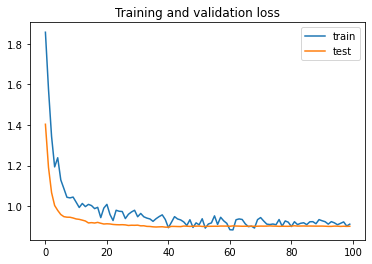

In [ ]:
epochs = range(len(training_history.history['loss'])) # Get number of epochs

# plot loss learning curves
plt.plot(epochs, training_history.history['loss'], label = 'train')
plt.plot(epochs, training_history.history['val_loss'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

Text(0.5, 1.0, 'Training and validation accuracy')

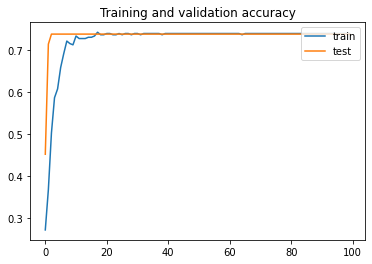

In [ ]:
# plot accuracy learning curves
plt.plot(epochs, training_history.history['acc'], label = 'train')
plt.plot(epochs, training_history.history['val_acc'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation accuracy')

In [ ]:
y_predci = model_Categorical_input.predict(X_cat_test)

In [ ]:
y_pred_ci=np.argmax(y_predci, axis=1)
y_test_ci=np.argmax(y_cat_test, axis=1)
cm_ci = confusion_matrix(y_test_ci, y_pred_ci)
print(cm_ci)

[[62  0  0  0  0]
 [ 8  0  0  0  0]
 [ 6  0  0  0  0]
 [ 6  0  0  0  0]
 [ 2  0  0  0  0]]


In [ ]:
from sklearn import metrics
print('Report:' + '\n', metrics.classification_report(y_test_ci,y_pred_ci))
print('Cm:' + '\n', metrics.confusion_matrix(y_test_ci,y_pred_ci))

Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85        62
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.74        84
   macro avg       0.15      0.20      0.17        84
weighted avg       0.54      0.74      0.63        84

Cm:
 [[62  0  0  0  0]
 [ 8  0  0  0  0]
 [ 6  0  0  0  0]
 [ 6  0  0  0  0]
 [ 2  0  0  0  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


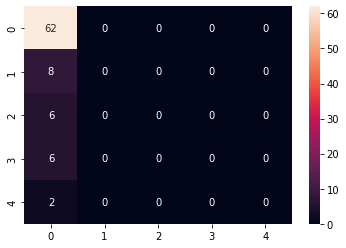

In [ ]:
f = sns.heatmap(cm_ci, annot=True, fmt='d')

In [ ]:
# serialize weights to HDF5
model_Categorical_input.save_weights("model_Categorical_input.h5")
print("Saved model weights to disk")

#Pickle file
filename = 'model_Categorical_input.pkl'
pickle.dump(model_Categorical_input, open(filename, 'wb'))

Saved model weights to disk
INFO:tensorflow:Assets written to: ram://42965f47-0ce5-4ade-aa46-cc16fcdce34b/assets


INFO:tensorflow:Assets written to: ram://42965f47-0ce5-4ade-aa46-cc16fcdce34b/assets


LSTM with multi input

In [ ]:
embedding_size

50

In [ ]:
vocab_size

2889

In [ ]:
inp_1 = Input(shape=(maxlen,))
inp_1 = Conv1D(64,3)(inp_1)
inp_1 = Dense(62, activation='relu')(inp_1)

inp_2 = Input(shape = (20,20))
inp_2 = LSTM(20, activation='relu')(inp_2)

concat_layer = Concatenate()([inp_1, inp_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(5, activation='softmax')(dense_layer_3)
# Model definition

model = Model(inputs=[inp_1, inp_2], outputs=output)


ValueError: ignored

In [ ]:
input_1 = Input(shape=(maxlen,))
embedding_layer   = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=True)(input_1)
LSTM_Layer_1      = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
max_pool_layer_1  = GlobalMaxPool1D()(LSTM_Layer_1)
drop_out_layer_1  = Dropout(0.5, input_shape = (256,))(max_pool_layer_1)
dense_layer_1     = Dense(128, activation = 'relu')(drop_out_layer_1)
drop_out_layer_2  = Dropout(0.5, input_shape = (128,))(dense_layer_1)
dense_layer_2     = Dense(64, activation = 'relu')(drop_out_layer_2)
drop_out_layer_3  = Dropout(0.5, input_shape = (64,))(dense_layer_2)

dense_layer_3     = Dense(32, activation = 'relu')(drop_out_layer_3)
drop_out_layer_4  = Dropout(0.5, input_shape = (32,))(dense_layer_3)

dense_layer_4     = Dense(10, activation = 'relu')(drop_out_layer_4)
drop_out_layer_5 = Dropout(0.5, input_shape = (10,))(dense_layer_4)

#submodel
param = 1e-4

input_2 = Input(shape=(X_cat_train.shape[1],))
dense_layer_5       = Dense(10, input_dim=X_cat_train.shape[1], activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(param),
                      kernel_constraint=unit_norm())(input_2)
drop_out_layer_6    = Dropout(0.2)(dense_layer_5)
batch_norm_layer_1  = BatchNormalization()(drop_out_layer_6)
dense_layer_6       = Dense(10, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(param), 
                            kernel_constraint=unit_norm())(batch_norm_layer_1)
drop_out_layer_7   = Dropout(0.5)(dense_layer_6)
batch_norm_layer_2 = BatchNormalization()(drop_out_layer_7)

concat_layer        = Concatenate()([drop_out_layer_5, batch_norm_layer_2])
dense_layer_7       = Dense(10, activation='relu')(concat_layer)
output  = Dense(5, activation='softmax')(dense_layer_7)
model_multiple_input   = Model(inputs=[input_1, input_2], outputs=output)

opt = SGD(learning_rate=0.001, momentum=0.9)
model_multiple_input.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [ ]:
embedding_matrix.shape

(2889, 50)

In [ ]:
input_1 = Input(shape=(maxlen,))
embedding_layer   = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=True)(input_1)
print(embedding_layer)
LSTM_Layer_1      = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
print(LSTM_Layer_1)

dense_layer_1     = Conv1D(256,3, activation = 'relu')(LSTM_Layer_1)
print(dense_layer_1.shape)

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 50), dtype=tf.float32, name=None), name='embedding_11/embedding_lookup/Identity_1:0', description="created by layer 'embedding_11'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 256), dtype=tf.float32, name=None), name='bidirectional_11/concat:0', description="created by layer 'bidirectional_11'")
(None, 98, 256)


In [ ]:
input_1 = Input(shape=(maxlen,))
embedding_layer   = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=True)(input_1)
print(embedding_layer)
LSTM_Layer_1      = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
print(LSTM_Layer_1)
dense_layer_1     = Conv1D(256,3, activation = 'relu')(LSTM_Layer_1)

print(dense_layer_1.shape)
#submodel
param = 1e-4

input_2 = Input(shape=(None,X_cat_train.shape[1],))
print(input_2.shape)
dense_layer_5       = Dense(10, input_dim=X_cat_train.shape[1], activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(param),
                      kernel_constraint=unit_norm())(input_2)
print(dense_layer_5.shape)

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 50), dtype=tf.float32, name=None), name='embedding_19/embedding_lookup/Identity_1:0', description="created by layer 'embedding_19'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 256), dtype=tf.float32, name=None), name='bidirectional_19/concat:0', description="created by layer 'bidirectional_19'")
(None, 98, 256)
(None, None, 5)
(None, None, 10)


In [ ]:
input_1 = Input(shape=(maxlen,))
embedding_layer   = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=True)(input_1)
print(embedding_layer)
LSTM_Layer_1      = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
print(LSTM_Layer_1)
dense_layer_1     = Conv1D(256,3, activation = 'relu')(LSTM_Layer_1)


#submodel
param = 1e-4

input_2 = Input(shape=(None,X_cat_train.shape[1],))
dense_layer_5       = Dense(10, input_dim=X_cat_train.shape[1], activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(param),
                      kernel_constraint=unit_norm())(input_2)
drop_out_layer_6    = Dropout(0.2)(dense_layer_5)
batch_norm_layer_1  = BatchNormalization()(drop_out_layer_6)
dense_layer_6       = Dense(10, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(param), 
                            kernel_constraint=unit_norm())(batch_norm_layer_1)
drop_out_layer_7   = Dropout(0.5)(dense_layer_6)
batch_norm_layer_2 = BatchNormalization()(drop_out_layer_7)

concat_layer        = Concatenate()([dense_layer_1, batch_norm_layer_2])
dense_layer_7       = Dense(10, activation='relu')(concat_layer)
output  = Dense(5, activation='softmax')(dense_layer_7)
model_multiple_input   = Model(inputs=[input_1, input_2], outputs=output)

opt = SGD(learning_rate=0.001, momentum=0.9)
model_multiple_input.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 50), dtype=tf.float32, name=None), name='embedding_20/embedding_lookup/Identity_1:0', description="created by layer 'embedding_20'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 256), dtype=tf.float32, name=None), name='bidirectional_20/concat:0', description="created by layer 'bidirectional_20'")


In [ ]:
print(model_multiple_input.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, None, 5)]    0           []                               
                                                                                                  
 dense_16 (Dense)               (None, None, 10)     60          ['input_31[0][0]']               
                                                                                                  
 dropout_18 (Dropout)           (None, None, 10)     0           ['dense_16[0][0]']               
                                                                                                  
 input_30 (InputLayer)          [(None, 100)]        0           []                               
                                                                                            

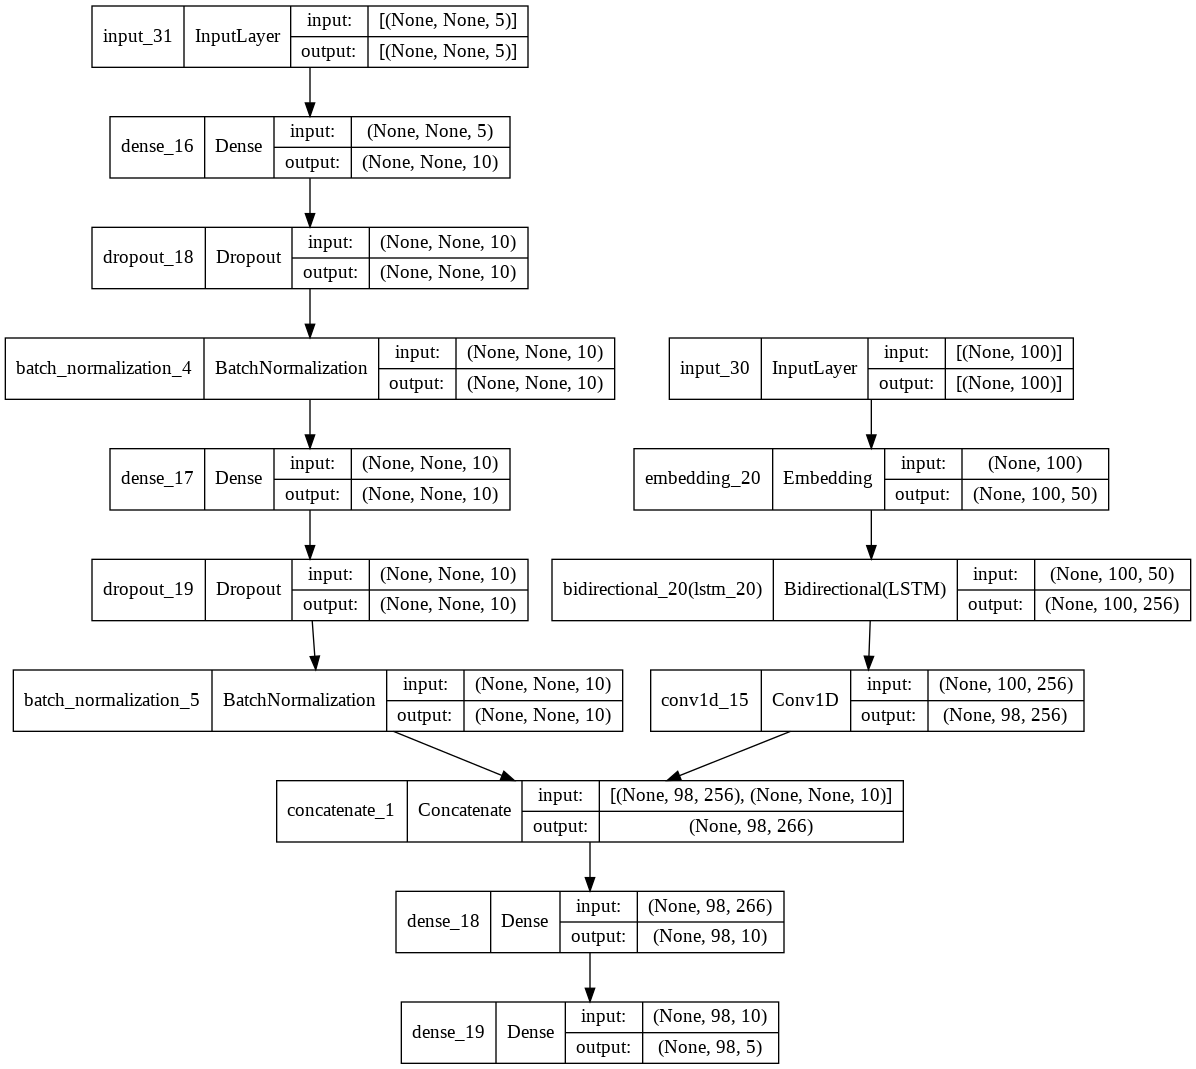

In [ ]:
plot_model(model_multiple_input, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [ ]:
X_text_train.shape

(334, 100)

In [ ]:
y_cat_train.shape

(334, 5)

In [ ]:
 #Use earlystopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, min_delta=1E-3)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=5, min_delta=1E-4)

target_type = 'multi_label'
metrics = Metrics(validation_data=([(None,X_text_train), (None,X_cat_train)], (None,y_cat_train), target_type))

# fit the keras model on the dataset
training_history = model_multiple_input.fit([(None,X_text_train, X_cat_train],y_cat_train, epochs=100, batch_size=8, verbose=1, validation_data=([(None,X_text_test),(None,X_cat_test)], y_cat_test), callbacks=[rlrp, metrics])

SyntaxError: ignored

In [ ]:
# evaluate the keras model
_, train_accuracy = model_multiple_input.evaluate([X_text_train, X_cat_train], y_cat_train, batch_size=8, verbose=0)
_, test_accuracy = model_multiple_input.evaluate([X_text_test, X_cat_test], y_cat_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 73.95
Test accuracy: 73.81


In [ ]:
accuracy, precision, recall, f1 = get_classification_metrics(model_multiple_input, [X_text_test, X_cat_test], y_cat_test, target_type)
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)

Accuracy: 0.738095
Precision: 0.738095
Recall: 0.738095
F1 score: 0.738095


Text(0.5, 1.0, 'Training and validation loss')

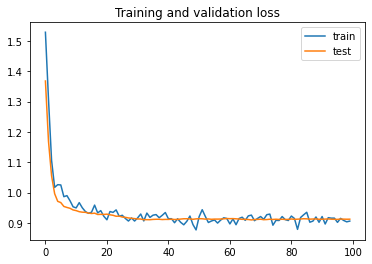

In [ ]:
epochs = range(len(training_history.history['loss'])) # Get number of epochs

# plot loss learning curves
plt.plot(epochs, training_history.history['loss'], label = 'train')
plt.plot(epochs, training_history.history['val_loss'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

Text(0.5, 1.0, 'Training and validation accuracy')

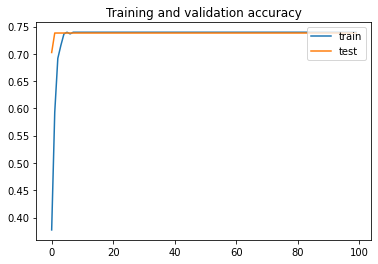

In [ ]:
# plot accuracy learning curves
plt.plot(epochs, training_history.history['acc'], label = 'train')
plt.plot(epochs, training_history.history['val_acc'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation accuracy')

In [ ]:
# serialize weights to HDF5
model_Categorical_input.save_weights("model_multiple_input.h5")
print("Saved model weights to disk")

#Pickle file
filename = 'model_multiple_input.pkl'
pickle.dump(model_multiple_input, open(filename, 'wb'))

Saved model weights to disk


INFO:tensorflow:Assets written to: ram://9fa4396a-0f00-4d09-8c86-407cf2bcfd0c/assets


INFO:tensorflow:Assets written to: ram://9fa4396a-0f00-4d09-8c86-407cf2bcfd0c/assets


In [ ]:
y_predmi = model_multiple_input.predict([X_text_test, X_cat_test])

In [ ]:
y_pred_mi=np.argmax(y_predmi, axis=1)
y_test_mi=np.argmax(y_cat_test, axis=1)
cm_mi = confusion_matrix(y_test_mi, y_pred_mi)
print(cm_mi)

[[62  0  0  0  0]
 [ 8  0  0  0  0]
 [ 6  0  0  0  0]
 [ 6  0  0  0  0]
 [ 2  0  0  0  0]]


In [ ]:
print('Report:' + '\n', metrics.classification_report(y_test_mi,y_pred_mi))
print('Cm:' + '\n', metrics.confusion_matrix(y_test_mi,y_pred_mi))

Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85        62
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.74        84
   macro avg       0.15      0.20      0.17        84
weighted avg       0.54      0.74      0.63        84

Cm:
 [[62  0  0  0  0]
 [ 8  0  0  0  0]
 [ 6  0  0  0  0]
 [ 6  0  0  0  0]
 [ 2  0  0  0  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


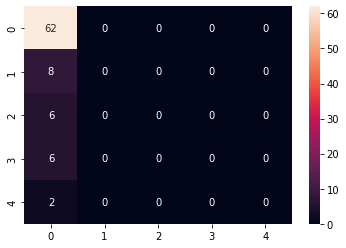

In [ ]:
f = sns.heatmap(cm_mi, annot=True, fmt='d')

Data Augmentation

In [ ]:
df["Accident_Level"].value_counts(normalize=True)


1    0.739234
2    0.095694
3    0.074163
4    0.071770
5    0.019139
Name: Accident_Level, dtype: float64

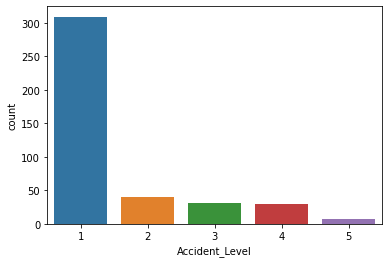

In [ ]:
sns.countplot(x = 'Accident_Level', data = df)

In [ ]:
df = df[['Description_normalized', 'Accident_Level']]

In [ ]:
train,valid=train_test_split(df,test_size=0.15)

In [ ]:
print('Shape of train',train.shape)
print("Shape of Validation ",valid.shape)

Shape of train (355, 2)
Shape of Validation  (63, 2)


In [ ]:
import nlpaug.augmenter.word as naw
aug = naw.SynonymAug()

In [ ]:
train.head(5)

,Description_normalized,Accident_Level
196,servant would remove dishes bowl sink picking ...,1
231,intersection level 3970 main road access south...,1
359,mixer 01 e c incimmet moved positive south ram...,2
198,topographic survey stp 440 east zone victim co...,1
136,field trip lt 01 lakes target junior da costa ...,2


In [ ]:
valid.head(5)

,Description_normalized,Accident_Level
1,activation sodium sulfide pump piping coupled ...,1
288,preparation scaffolding activity employee load...,1
33,approximately 1 40 p circumstances shotcrete l...,5
107,employee reports climbing access ladder operat...,1
45,time two assistants carrying bag cement weighi...,1


In [ ]:
aug_syn = naw.SynonymAug(aug_src='wordnet')

In [ ]:
pip install tqdm

In [ ]:
from sklearn.utils import shuffle

def augment_text(df,samples=300,pr=0.2):
    aug_syn.aug_p=pr
    new_text=[]
    Accident_Level_new=[]
    
    ##dropping samples from validation
    df_n=df[df.Accident_Level!=1].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
        
            text = df.iloc[i]['Description_normalized']
            augmented_text = aug_syn.augment(text)
            new_text.append(augmented_text)
            Accident_Level_text=df_n.iloc[i]['Accident_Level']
            Accident_Level_new.append(Accident_Level_text)
            
    
    
    ## dataframe
    new=pd.DataFrame({'Description_normalized':new_text,'Accident_Level':Accident_Level_new})
    df=shuffle(df.append(new).reset_index(drop=True))
    return df

In [ ]:
train = augment_text(train,samples=400)   ## change samples to 0 for no augmentation

100%|██████████| 400/400 [00:03<00:00, 113.56it/s]


In [ ]:
train.shape

(755, 2)

In [ ]:
train.head()

,Description_normalized,Accident_Level
383,employee transiting gas area came slip sufferi...,3
500,employee reports performed routine activity ar...,2
705,orbit bodily process amg project fair game lui...,2
1,intersection level 3970 main road access south...,1
358,employee reports working brushcutters near sto...,3


In [ ]:
train.isna().any()

Description_normalized    False
Accident_Level            False
dtype: bool

In [ ]:
train["Accident_Level"].value_counts(normalize=True)

1    0.340397
2    0.233113
3    0.202649
4    0.169536
5    0.054305
Name: Accident_Level, dtype: float64

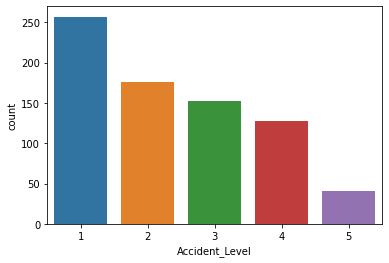

In [ ]:
sns.countplot(x = 'Accident_Level', data = train)

In [ ]:
# Select input and output features of training dataset
X_train_DA = train['Description_normalized']
y_train_DA = train['Accident_Level']

In [ ]:
# Select input and output features of testing dataset
X_valid_DA = valid['Description_normalized']
y_valid_DA = valid['Accident_Level']

In [ ]:
X_train_DA

383    employee transiting gas area came slip sufferi...
500    employee reports performed routine activity ar...
705    orbit bodily process amg project fair game lui...
1      intersection level 3970 main road access south...
358    employee reports working brushcutters near sto...
                             ...                        
231    collaborator reports street 09 holding left ha...
235    circumstances operator scooptram proceeded sit...
132    master additive taken afd 755 license plate to...
577    mixer 01 e ascorbic acid incimmet moved positi...
83     circumstances drilling assistants proceeded as...
Name: Description_normalized, Length: 755, dtype: object

In [ ]:
# Encode labels in column 'Accident Level'.
from sklearn.preprocessing import LabelEncoder
y_train_DA = LabelEncoder().fit_transform(y_train_DA)

In [ ]:
from keras.utils import np_utils
# Convert both the training and test labels into one-hot encoded vectors:
# Convert both the training and test labels into one-hot encoded vectors:
y_train_DA = np_utils.to_categorical(y_train_DA)
y_valid_DA = np_utils.to_categorical(y_valid_DA)

In [ ]:
# Keras pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_DA)

X_train_DA = tokenizer.texts_to_sequences(X_train_DA)
X_valid_DA = tokenizer.texts_to_sequences(X_valid_DA)

In [ ]:
# Sentences can have different lengths, and therefore the sequences returned by the Tokenizer class also consist of variable lengths.
# We need to pad the our sequences using the max length.
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:", vocab_size)

maxlen = 100

X_train_DA = pad_sequences(X_train_DA, padding='post', maxlen=maxlen)
X_valid_DA = pad_sequences(X_valid_DA, padding='post', maxlen=maxlen)

vocab_size: 3906


In [ ]:
embedding_size = 50
embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/Colab Notebooks/glove.6B.50d (3).txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

len(embeddings_dictionary.values())

400000

In [ ]:
from keras.layers import Input
from tensorflow.keras.layers import Flatten, Activation, Dense, LSTM, BatchNormalization, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from tensorflow.keras.optimizers import SGD
# Build a LSTM Neural Network
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=False)(deep_inputs)

LSTM_Layer_1 = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
max_pool_layer_1 = GlobalMaxPool1D()(LSTM_Layer_1)
drop_out_layer_1 = Dropout(0.5, input_shape = (256,))(max_pool_layer_1)
dense_layer_1 = Dense(128, activation = 'relu')(drop_out_layer_1)
drop_out_layer_2 = Dropout(0.5, input_shape = (128,))(dense_layer_1)
dense_layer_2 = Dense(64, activation = 'relu')(drop_out_layer_2)
drop_out_layer_3 = Dropout(0.5, input_shape = (64,))(dense_layer_2)
dense_layer_3 = Dense(32, activation = 'relu')(drop_out_layer_3)
drop_out_layer_4 = Dropout(0.5, input_shape = (32,))(dense_layer_3)
dense_layer_4 = Dense(10, activation = 'relu')(drop_out_layer_4)
drop_out_layer_5 = Dropout(0.5, input_shape = (10,))(dense_layer_4)
dense_layer_5 = Dense(5, activation='softmax')(drop_out_layer_5)
model_lstm_text_input_DA = Model(inputs=deep_inputs, outputs=dense_layer_5)
opt = SGD(learning_rate=0.001, momentum=0.9)
model_lstm_text_input_DA.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [ ]:
print(model_lstm_text_input_DA.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 50)           195300    
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 256)         183296    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               3289

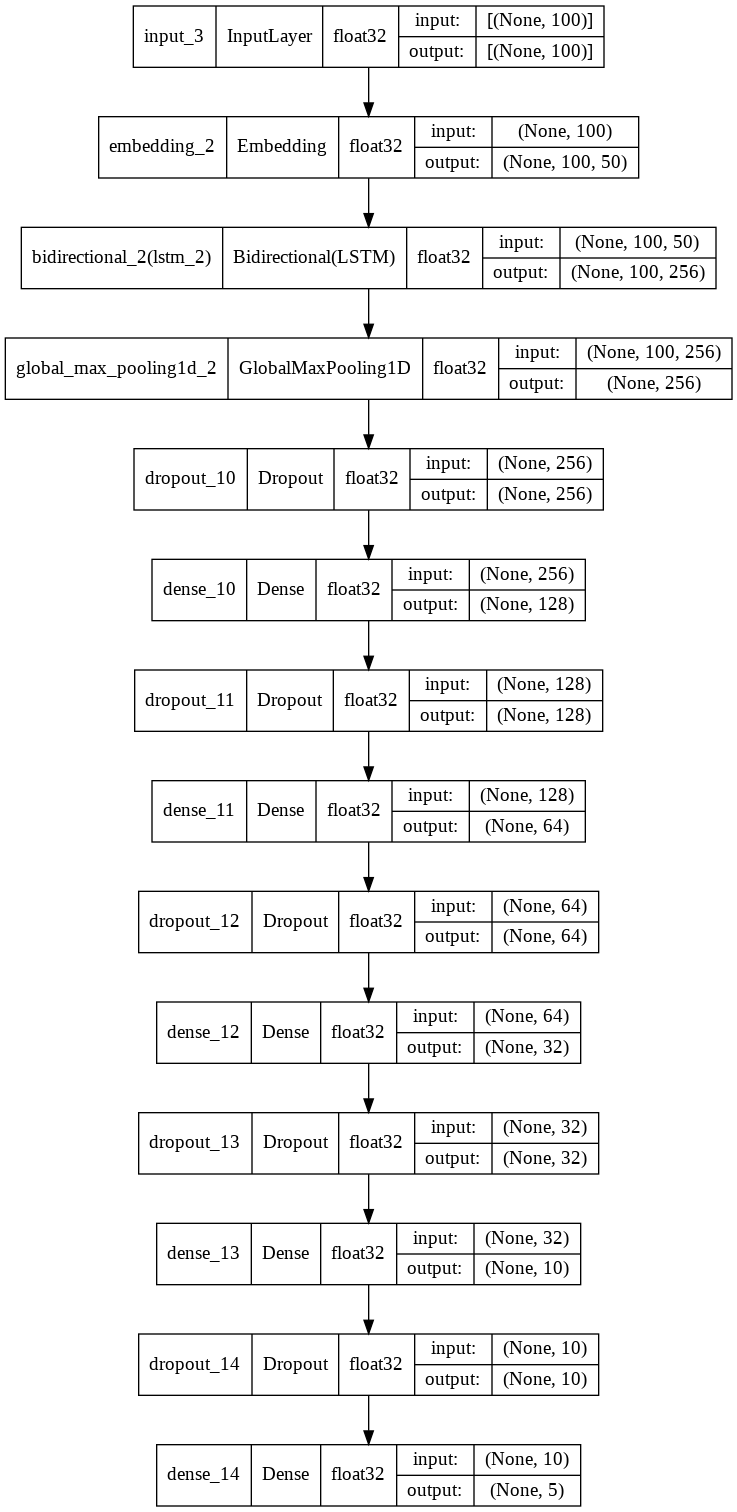

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_lstm_text_input_DA, to_file='model_plot1.png', show_shapes=True, show_dtype=True, show_layer_names=True)

In [ ]:
class Metrics(tf.keras.callbacks.Callback):

    def __init__(self, validation_data=()):
        super().__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        xVal, yVal, target_type = self.validation_data
        if target_type == 'multi_class':
          val_predict_classes = model.predict_classes(xVal, verbose=0) # Multiclass
        else:
          val_predict_classes = (np.asarray(self.model.predict(xVal))).round() # Multilabel
        
        
        val_targ = yVal

        _val_f1 = f1_score(val_targ, val_predict_classes, average='micro')
        _val_recall = recall_score(val_targ, val_predict_classes, average='micro')
        _val_precision = precision_score(val_targ, val_predict_classes, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        #print("— train_f1: %f — train_precision: %f — train_recall %f" % (_val_f1, _val_precision, _val_recall))
        return

In [ ]:
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
# Use earlystopping
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, min_delta=1E-3)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=5, min_delta=1E-4)

target_type = 'multi_label'
metrics = Metrics(validation_data=(X_train_DA, y_train_DA, target_type))

# fit the keras model on the dataset
training_history = model_lstm_text_input_DA.fit(X_train_DA, y_train_DA, epochs=100, batch_size=8, verbose=1, validation_data=(X_valid_DA, y_valid_DA), callbacks=[rlrp, metrics])

Epoch 1/100
94/95 [============================>.] - ETA: 0s - loss: 1.6810 - acc: 0.2513

ValueError: ignored

In [ ]:
# evaluate the keras model
_, train_accuracy = model_lstm_text_input_DA.evaluate(X_text_train, y_text_train, batch_size=8, verbose=0)
_, test_accuracy = model_lstm_text_input_DA.evaluate(X_text_test, y_text_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 56.29
Test accuracy: 56.29
